# Credit Card Customer Attrition
## By: Swaraj Tripathy

The goal of this analysis is to identify credit card customers who closed their credit card accounts as credit cards provide significant revenue for banks. By identifying customers who are closing their credit card accounts, the bank can make changes to their policies or credit card benefits to improve customer retention. I will be developing a hyperparameter tuned classification model to identify these customers using the RandomSearchCV algorithm, then developing a pipeline using this model for reproducability.

This analysis aims to answer the following questions: What kinds of customers are likely to close their credit card accounts? What features are most important when identifying customers who are likely to close their accounts? Can I develop an accurate, robust model and a machine learning pipeline to identify these customer in a production setting?

In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
# load and explore the original dataset
raw_data = pd.read_csv("BankChurners.csv")
data = raw_data.copy()
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


The Attrition_Flag variable is our target, while all other variables are potential features in the model. We are going to drop the CLIENTNUM variable as it does not add any information to our analysis.

In [3]:
# drop the CLIENTNUM column
data = data.drop("CLIENTNUM", axis = 1)

In [4]:
# shape of dataset
data.shape

(10127, 20)

In [5]:
# number of duplicate rows
data.duplicated().sum()

0

In [6]:
# statistical summary of numerical variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


The Credit_Limit and Avg_Open_To_Buy seem to be skewed to the right distributions as the means are significantly higher than the medians. We may need to treat some outliers for these columns. All other numerical columns are relatively unskewed. 

In [7]:
# datatypes and null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           8608 non-null   object 
 5   Marital_Status            9378 non-null   object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [8]:
# replace "abc" values in the Income_Category column with np.nan so we can impute the median later
data["Income_Category"].replace("abc", np.nan, inplace = True)

We want to make sure all variables are either numerical or categorical variables to help keep track of our datatypes.

In [9]:
# convert object datatypes to categorical variables
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature])# Replace strings with an integer
        
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           9015 non-null   category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [10]:
# target variable value_counts to see if the data is unbalanced
data["Attrition_Flag"].value_counts(normalize = True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

The data is pretty unbalanced with only 16% of the customers closing their credit card accounts. We will deal with the data imbalance later with sampling techniques.

In [11]:
# encode the target variable with 1's and 0's
data["Attrition_Flag"] = data["Attrition_Flag"].replace(["Attrited Customer", "Existing Customer"], [1, 0])
data["Attrition_Flag"] = pd.to_numeric(data["Attrition_Flag"])

In [12]:
# total missing value counts
data.isnull().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

Education_Level and Marital_Status are the only columns with missing values, but we added some to fix the Income_Category column. Since all are categorical variables, we will impute the median into those rows with the SimpleImputer.

In [13]:
# split the data into X and y so that we can create a test, train, and validation set
# we want to do this early to prevent data leakage when doing preprocessing like missing value imputation
X = data.drop(["Attrition_Flag"], axis = 1)
y = data["Attrition_Flag"]

In [14]:
# Splitting data into training, validation and test set:

# first we split data into 2 parts, temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1, stratify = y
)

# then we split the temporary set into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size = 0.2, random_state = 1, stratify = y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)

(6480, 19) (1621, 19) (2026, 19)


In [15]:
# check the missing values in all sets
print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(X_test.isnull().sum())

Customer_Age                  0
Gender                        0
Dependent_count               0
Education_Level             988
Marital_Status              477
Income_Category             690
Card_Category                 0
Months_on_book                0
Total_Relationship_Count      0
Months_Inactive_12_mon        0
Contacts_Count_12_mon         0
Credit_Limit                  0
Total_Revolving_Bal           0
Avg_Open_To_Buy               0
Total_Amt_Chng_Q4_Q1          0
Total_Trans_Amt               0
Total_Trans_Ct                0
Total_Ct_Chng_Q4_Q1           0
Avg_Utilization_Ratio         0
dtype: int64
Customer_Age                  0
Gender                        0
Dependent_count               0
Education_Level             234
Marital_Status              120
Income_Category             185
Card_Category                 0
Months_on_book                0
Total_Relationship_Count      0
Months_Inactive_12_mon        0
Contacts_Count_12_mon         0
Credit_Limit               

In [16]:
# impute the missing values using the median value from the training data to prevent data leakeage
imp_mode = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

# fit the imputer on train data and transform the train data
X_train["Education_Level"] = imp_mode.fit_transform(X_train[["Education_Level"]])

# transform the validation and test data using the imputer fit on train data
X_val["Education_Level"] = imp_mode.transform(X_val[["Education_Level"]])
X_test["Education_Level"] = imp_mode.transform(X_test[["Education_Level"]])

# fit the imputer on train data and transform the train data
X_train["Marital_Status"] = imp_mode.fit_transform(X_train[["Marital_Status"]])

# transform the validation and test data using the imputer fit on train data
X_val["Marital_Status"] = imp_mode.transform(X_val[["Marital_Status"]])
X_test["Marital_Status"] = imp_mode.transform(X_test[["Marital_Status"]])

# fit the imputer on train data and transform the train data
X_train["Income_Category"] = imp_mode.fit_transform(X_train[["Income_Category"]])

# transform the validation and test data using the imputer fit on train data
X_val["Income_Category"] = imp_mode.transform(X_val[["Income_Category"]])
X_test["Income_Category"] = imp_mode.transform(X_test[["Income_Category"]])

In [17]:
# check the missing values in all sets
print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(X_test.isnull().sum())

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy            

In [18]:
# create dummy variables for categorical columns. This makes feature importance easier to interpret
X_train = pd.get_dummies(X_train, drop_first = True)
X_val = pd.get_dummies(X_val, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

## Exploratory Data Analysis

### Univariate Analysis

In [19]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None, hue = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 5, 5))
    else:
        plt.figure(figsize=(n + 5, 5))

    plt.xticks(rotation=45, fontsize=10)
    plt.title(feature + " Distribution")
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue = hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [20]:
data.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

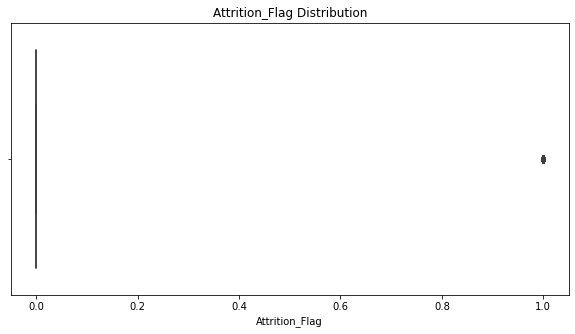

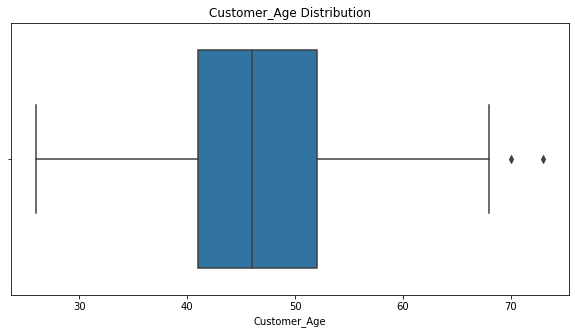

<Figure size 720x360 with 0 Axes>

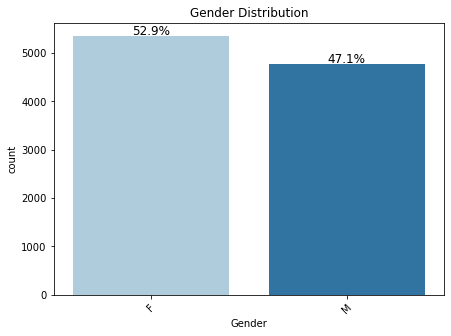

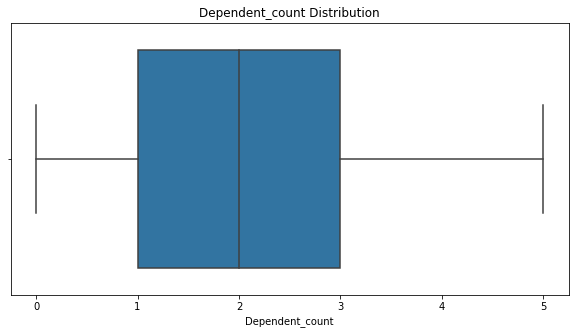

<Figure size 720x360 with 0 Axes>

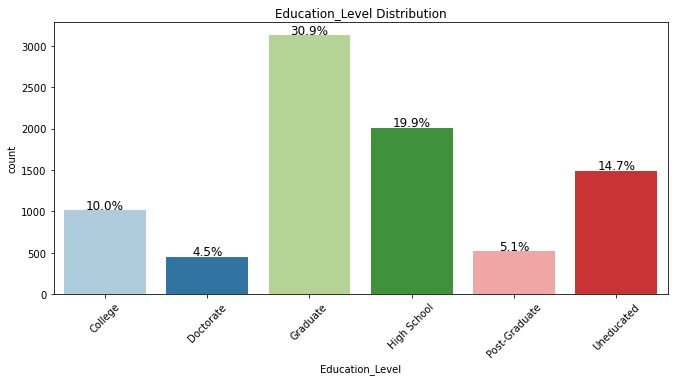

<Figure size 720x360 with 0 Axes>

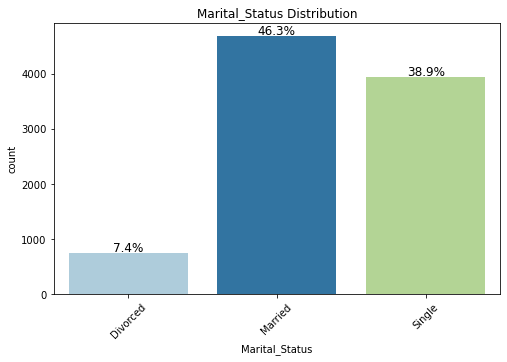

<Figure size 720x360 with 0 Axes>

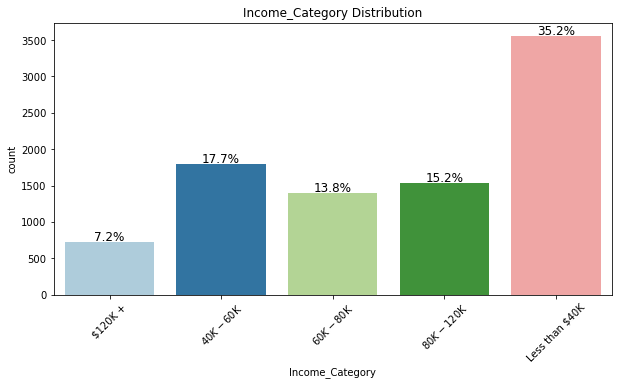

<Figure size 720x360 with 0 Axes>

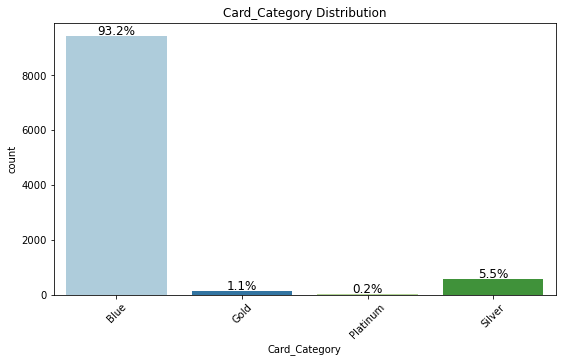

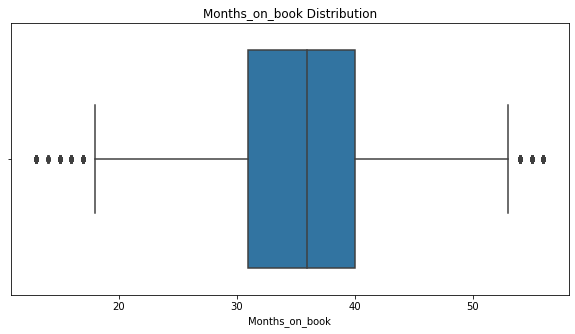

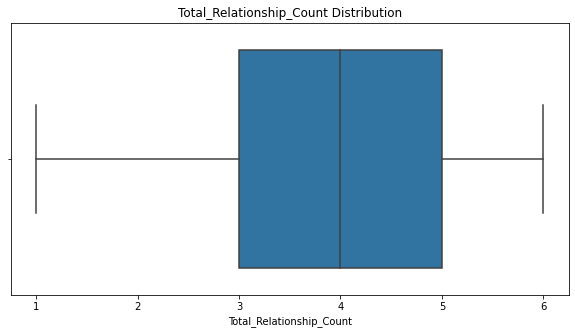

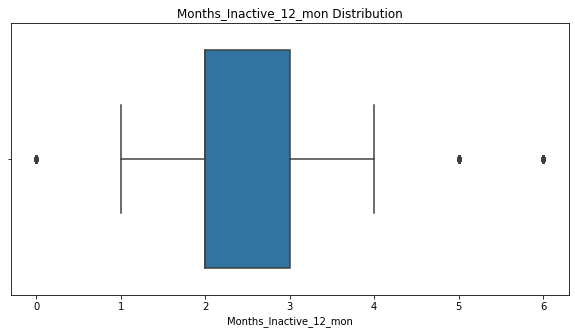

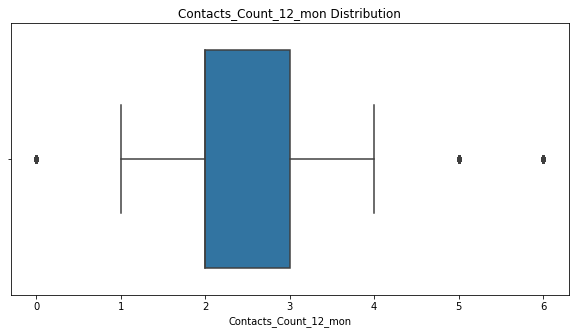

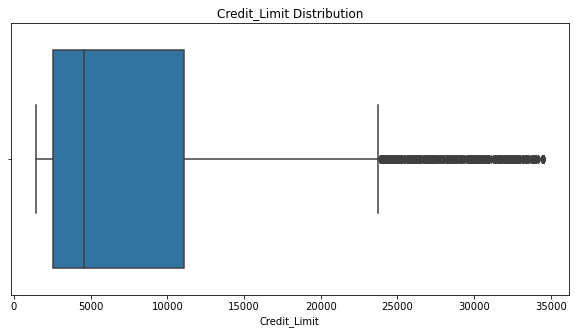

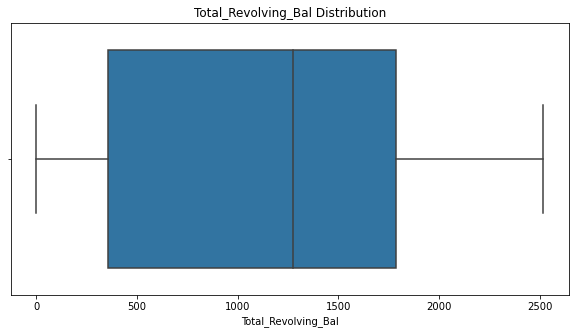

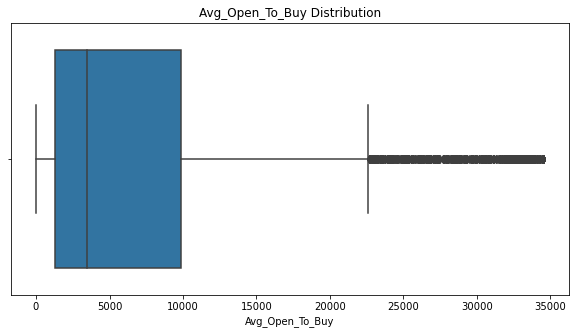

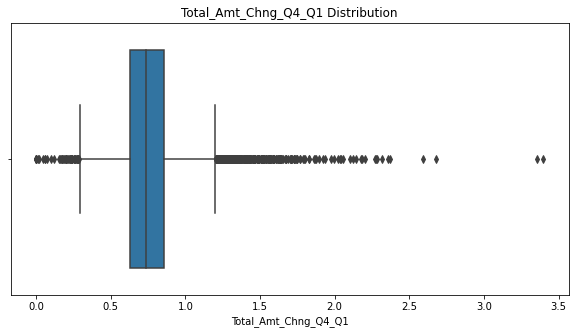

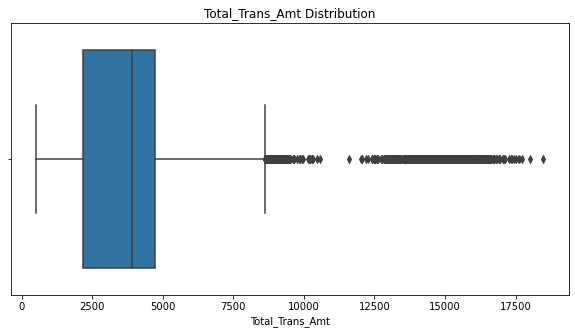

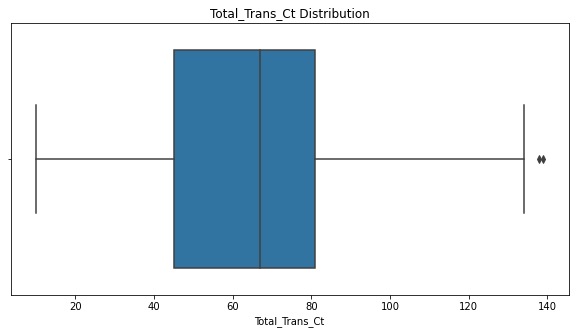

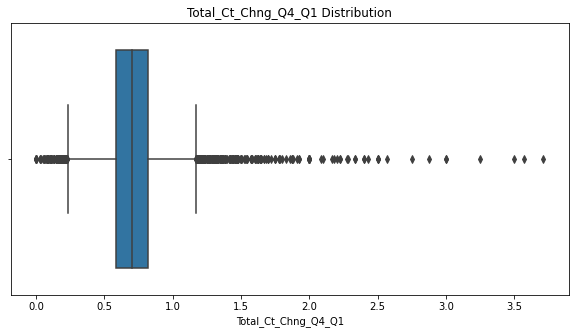

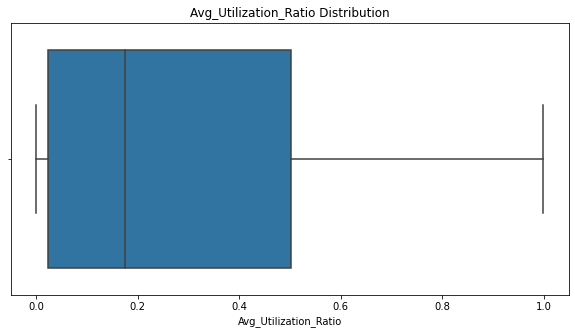

In [21]:
# loop through the columns and create a countplot for categorical variables and a scatterplot for numerical variables
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'float64' or data[feature].dtype == 'int64':
        plt.figure(figsize = (10,5))
        plt.title(feature + " Distribution")
        sns.boxplot(data = data, x = feature)
        plt.show()
    else:
        plt.figure(figsize = (10,5))
        labeled_barplot(data = data, feature = feature, perc = True)
        plt.show()

- Over 50% of customers are between 40-55 years old, but some as young as 26 and as old as 73
- The gender is pretty evenly distributed with about 50% for each gender
- Median number of dependents was 2, but ranged from 0-5
- The largest education category was graduate with over 30% of customers in that category
- Almost 50% of customers were married, with about 40% single
- The largest income category was the lowest of less than 40K, while the highest income group had the least customers. The other 3 categories in the middle were pretty evenly distributed with roughly 15% of customers in each
- Over 90% of customers had a blue card. It will be interesting to see if the other carf types are the ones that are being closed more often as they are not as popular
- Over 50% of customers spent between 30 and 40 months with the bank
- The customers had between 1 and 6 products with this bank, but 50% of customers had between 3-5 products
- In the past year, 50% of customers spent between 2-3 months inactive
- The bank contacted customers 0-6 times in the past year, but most were contacted 1-4 times
- The median credit limit was less than 5000, with the upper limit of the IQR at less than 25000. This distribution is skewed to the right
- We see a right skew in many of the financial metrics likely due to the disparity in income and credit limit
- We will chose not to treat these outliers as in many financial cases, there is a large real world gap in income and differences in liffestyles that can lead to the difference in these metrics. We will continue to use the high outliers for credit limit and other financial metrics as they are not unreasonably high, they are still realistic values that may add to our analysis.

### Bivariate Analysis

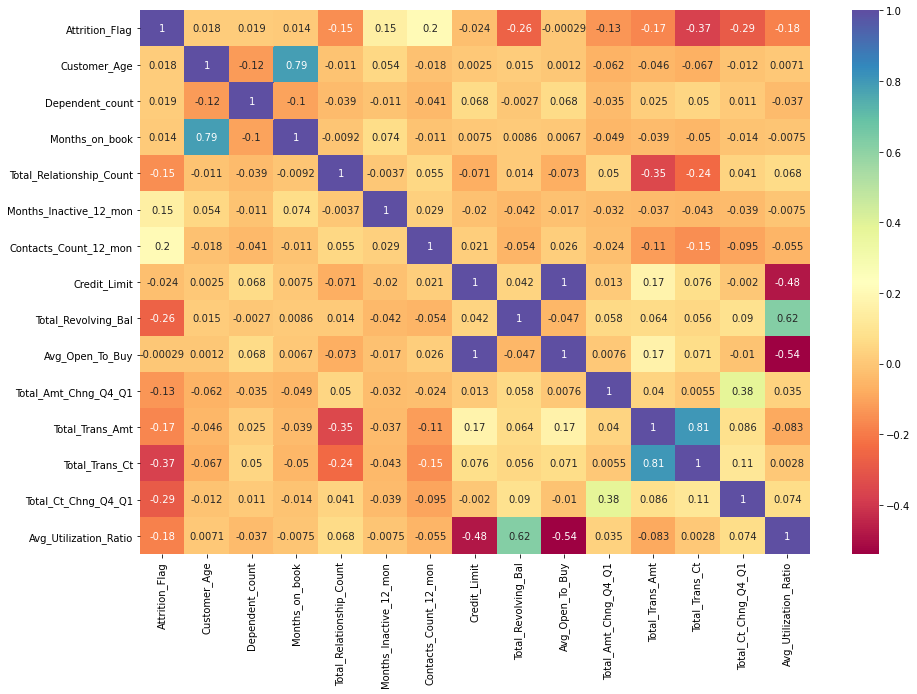

In [22]:
# heatmap of numerical variables
plt.figure(figsize = (15, 10))
sns.heatmap(data.corr(), annot = True, cmap = "Spectral");

The variables with the strongest relationship with the target are Total_Revolving_Bal, Total_Trans_Ct, and Total_Ct_Chng_Q4_Q1

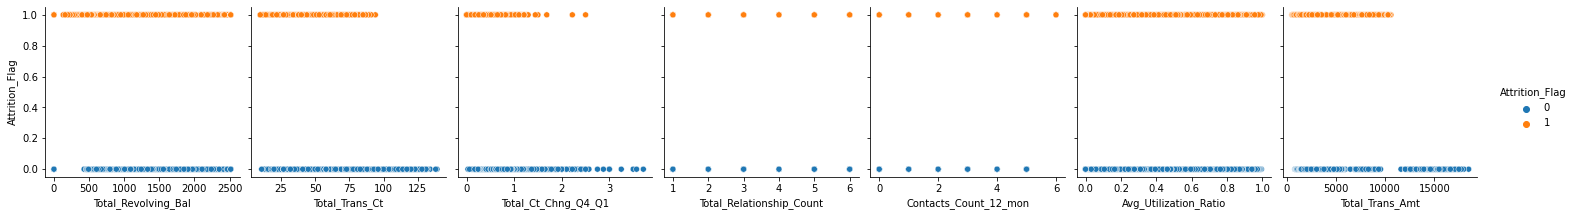

In [23]:
# pairplot to see relationship of numerical variables of interest with Attrition_Flag
sns.pairplot(
    data,
    x_vars=["Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Total_Relationship_Count", "Contacts_Count_12_mon", "Avg_Utilization_Ratio", "Total_Trans_Amt"],
    y_vars=["Attrition_Flag"],
    height=3,
    aspect=1,
    hue = "Attrition_Flag"
    );

- Only people with a Total_Trans_Ct of < 100 closed their account
- Only people with Total_Trans_Amt < 13000 closed their account
- Only people with Total_Ct_Chng_Q4_Q1 < 3 closed their account
- All customers who were contacted 6 times in the past year closed their account

<Figure size 720x360 with 0 Axes>

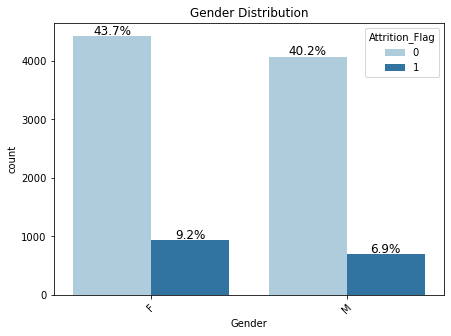

<Figure size 720x360 with 0 Axes>

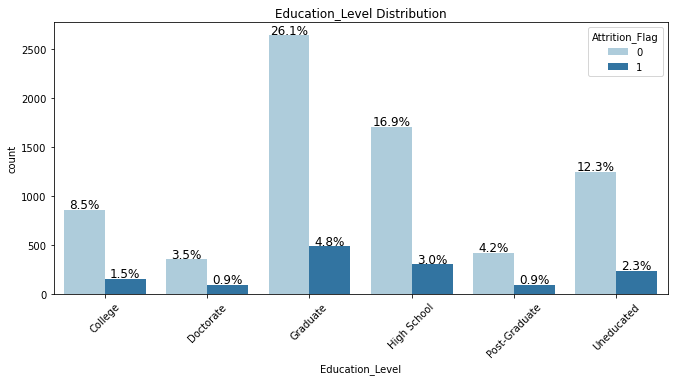

<Figure size 720x360 with 0 Axes>

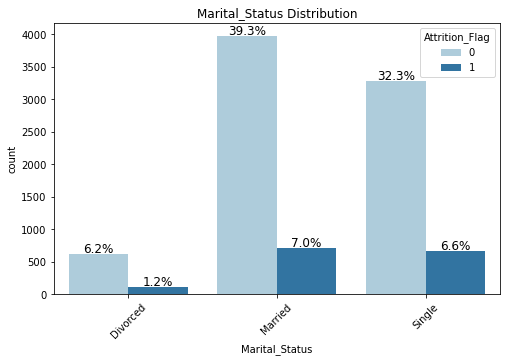

<Figure size 720x360 with 0 Axes>

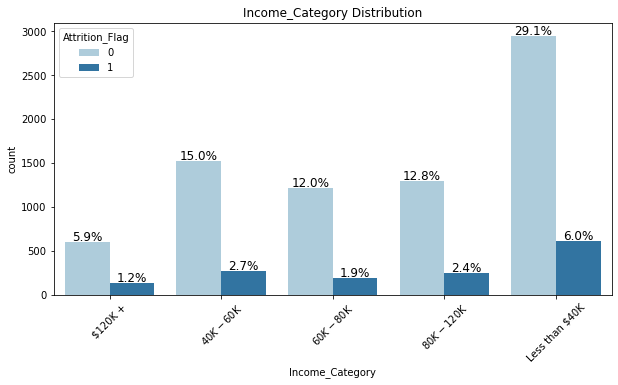

<Figure size 720x360 with 0 Axes>

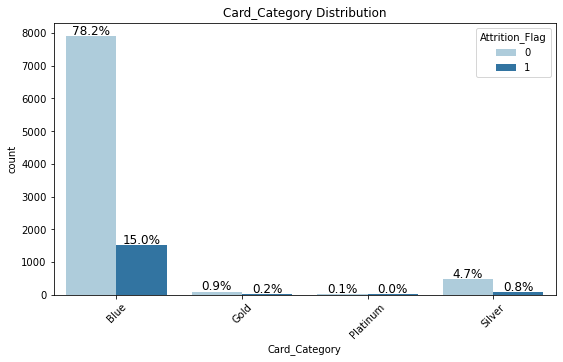

In [24]:
# create barplots with the Attrition_Flag for all categorical variables
for feature in data.columns:
    if data[feature].dtype.name == 'category':
        plt.figure(figsize = (10,5))
        labeled_barplot(data = data, feature = feature, perc = True, hue = "Attrition_Flag")
        plt.show()

- More females closed their accounts than males, but there were also slightly more female customers overall
- Graduates had the most attrited customers overall, but relative to sample size, the most Doctorates were attrited customers
- Almost the same amount of married and single customers were attrited, but there were more married customers overall
    - Relatively, single customers were most likely to close their accounts, but divorced customers had a similar attrition rate
- Customers making < 40K had the most attrited customers and also were the most likely to close their accounts, but customers making > 120K were all most as likely to close their accounts even though there were much less customers in this income category
- Customers with a gold card were the most likely to close their accounts, while platinum card holders were the least likely
    - Although most customers held a blue card, they were less likely to close their accounts than gold card members

## Model Building

I am going to try building 6 different classification models to predict whether or not a customer will close their credit card account. I will be using Logistic Regression, Decision Tree, Random Forest, Adaboost, Gradient Boosting, and XGBoost algorithms to fit the models. I will start with fitting the models to the data as is, and then try oversampling and undersampling methods to help with the imbalance in the data. I will compare the performance of these models with the different sampling techniques before identifying the three best performing ones to be hyperparameter tuned using the RandomSearchCV method. We will then compare the model performance of the three tuned models before creating a pipeline to streamline this process. When evaluating model performance, we will be most concerned with recall, which looks to minimize false negatives, which is when our model predicts that a customer will not close their account when they actually will.

In [25]:
# import packages for model building
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

In [26]:
##  Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and f1 score
## Uses the validation set for model evaluation
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    val_acc = model.score(X_val,y_val)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    val_recall = metrics.recall_score(y_val,pred_val)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    val_precision = metrics.precision_score(y_val,pred_val)
    
    #f1 score of the model
    train_f1 = metrics.f1_score(y_train,pred_train)
    val_f1 = metrics.f1_score(y_val,pred_val)
    
    score_list.extend((train_acc,val_acc,train_recall,val_recall,train_precision,val_precision, train_f1, val_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on validation set : ",model.score(X_val,y_val))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on validation set : ",metrics.recall_score(y_val,pred_val))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on validation set : ",metrics.precision_score(y_val,pred_val))
        print("F1 Score on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1 Score on validation set : ",metrics.f1_score(y_val,pred_val))
    
    return score_list # returning the list with train and test scores

In [27]:
## Function to create confusion matrix using validation set for evaluation
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_val)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

First I will fit the default models using all 6 algorithms on the unbalanced data. We are evaluating all these models on the validation set because we will end up hyperparameter tuning the best models, so we don't want to tune them to the test set to avoid data leakage.

#### Logistic Regression

In [28]:
# Logistic Regression
log = LogisticRegression(random_state = 1)
log.fit(X_train, y_train)

LogisticRegression(random_state=1)

Accuracy on training set :  0.8839506172839506
Accuracy on validation set :  0.8895743368291178
Recall on training set :  0.38424591738712777
Recall on validation set :  0.42911877394636017
Precision on training set :  0.7827788649706457
Precision on validation set :  0.7887323943661971
F1 Score on training set :  0.5154639175257733
F1 Score on validation set :  0.5558312655086849


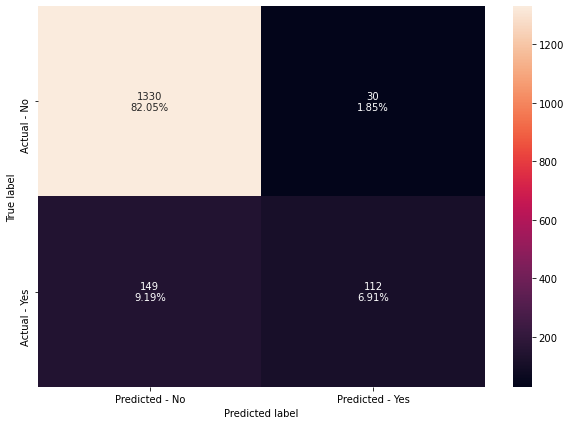

In [29]:
# check metrics scores
log_score = get_metrics_score(log)

# make a confusion matrix of our predictions
make_confusion_matrix(log, y_val)

#### Decision Tree

In [30]:
# Decision Tree
dtree = DecisionTreeClassifier(random_state = 1)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on validation set :  0.945712523133868
Recall on training set :  1.0
Recall on validation set :  0.8314176245210728
Precision on training set :  1.0
Precision on validation set :  0.8314176245210728
F1 Score on training set :  1.0
F1 Score on validation set :  0.8314176245210728


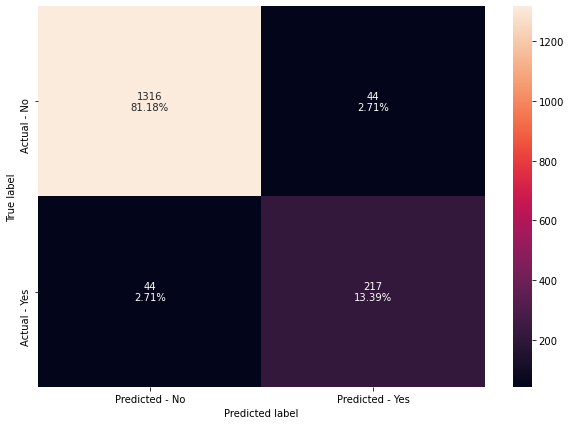

In [31]:
# check metrics scores
dtree_score = get_metrics_score(dtree)

# make a confusion matrix of our predictions
make_confusion_matrix(dtree, y_val)

#### Random Forest

In [32]:
# Random Forest
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on validation set :  0.9574336829117829
Recall on training set :  1.0
Recall on validation set :  0.8007662835249042
Precision on training set :  1.0
Precision on validation set :  0.9247787610619469
F1 Score on training set :  1.0
F1 Score on validation set :  0.8583162217659137


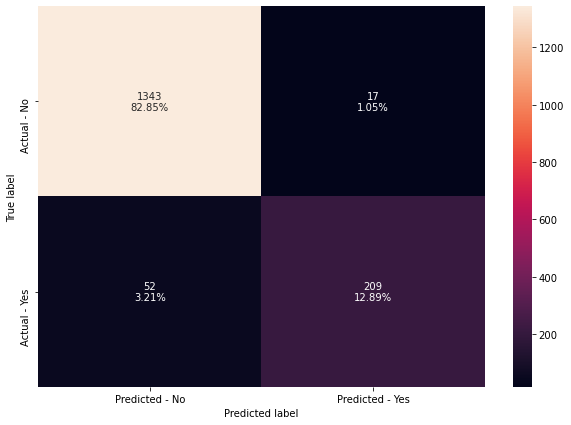

In [33]:
# check metrics scores
rf_score = get_metrics_score(rf)

# make a confusion matrix of our predictions
make_confusion_matrix(rf, y_val)

#### Bagging Classifier

In [34]:
# Bagging Classifier
bag = BaggingClassifier(random_state = 1)
bag.fit(X_train, y_train)

BaggingClassifier(random_state=1)

Accuracy on training set :  0.996141975308642
Accuracy on validation set :  0.9537322640345466
Recall on training set :  0.9769452449567724
Recall on validation set :  0.8160919540229885
Precision on training set :  0.9990176817288802
Precision on validation set :  0.8875
F1 Score on training set :  0.9878581835842642
F1 Score on validation set :  0.8502994011976048


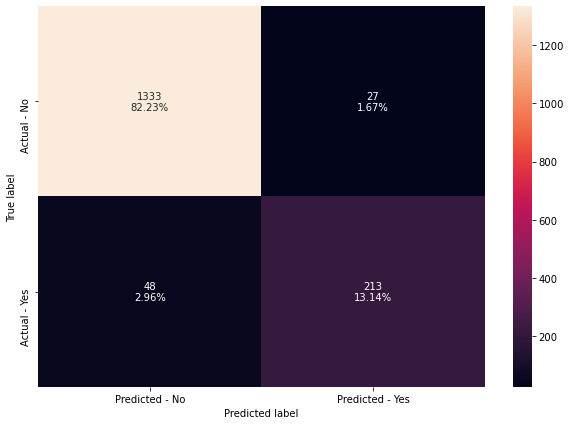

In [35]:
# check metrics scores
bag_score = get_metrics_score(bag)

# make a confusion matrix of our predictions
make_confusion_matrix(bag, y_val)

#### Adaboost

In [36]:
# AdaBoost
abc = AdaBoostClassifier(random_state = 1)
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

Accuracy on training set :  0.9587962962962963
Accuracy on validation set :  0.9568167797655768
Recall on training set :  0.8443804034582133
Recall on validation set :  0.842911877394636
Precision on training set :  0.8932926829268293
Precision on validation set :  0.8835341365461847
F1 Score on training set :  0.8681481481481482
F1 Score on validation set :  0.8627450980392158


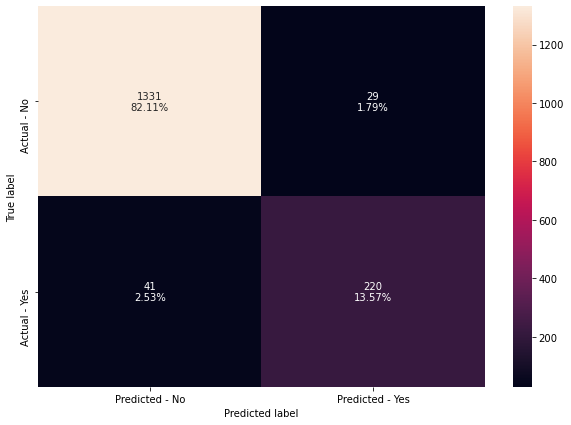

In [37]:
# check metrics scores
abc_score = get_metrics_score(abc)

# make a confusion matrix of our predictions
make_confusion_matrix(abc, y_val)

#### XGBoost

In [38]:
# XGBoost
xgb = XGBClassifier(random_state = 1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy on training set :  1.0
Accuracy on validation set :  0.9703886489821099
Recall on training set :  1.0
Recall on validation set :  0.89272030651341
Precision on training set :  1.0
Precision on validation set :  0.9209486166007905
F1 Score on training set :  1.0
F1 Score on validation set :  0.9066147859922179


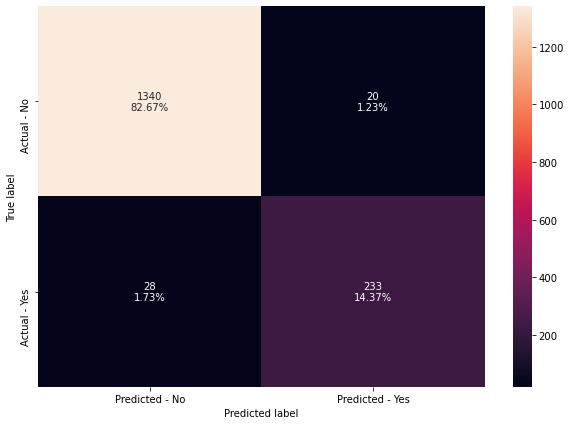

In [39]:
# check metrics scores
xgb_score = get_metrics_score(xgb)

# make a confusion matrix of our predictions
make_confusion_matrix(xgb, y_val)

In [40]:
# comparing model performance of default models
# defining list of models
models = [log, dtree, rf, bag, abc, xgb,
          ]

# defining empty lists to add train and validation results
acc_train = []
acc_val = []
recall_train = []
recall_val = []
precision_train = []
precision_val = []
f1_train = []
f1_val = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_val.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_val.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_val.append(np.round(j[5],2))
    f1_train.append(np.round(j[6],2))
    f1_val.append(np.round(j[7],2))

In [41]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression','Decision Tree',
                                        'Random Forest', 'Bagging Classifier', 
                                         'AdaBoost Classifier', "XGBoost Classifier"], 
                                          'Train_Accuracy': acc_train,'Validation_Accuracy': acc_val,
                                          'Train_Recall': recall_train,'Validation_Recall': recall_val,
                                          'Train_Precision': precision_train,'Validation_Precision': precision_val,
                                          'Train_F1_Score': f1_train, 'Validation_F1_Score': f1_val}) 
comparison_frame

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,Logistic Regression,0.88,0.89,0.38,0.43,0.78,0.79,0.52,0.56
1,Decision Tree,1.00,0.95,1.00,0.83,1.00,0.83,1.00,0.83
2,Random Forest,1.00,0.96,1.00,0.80,1.00,0.92,1.00,0.86
3,Bagging Classifier,1.00,0.95,0.98,0.82,1.00,0.89,0.99,0.85
4,AdaBoost Classifier,0.96,0.96,0.84,0.84,0.89,0.88,0.87,0.86
5,XGBoost Classifier,1.00,0.97,1.00,0.89,1.00,0.92,1.00,0.91


- All models were overfitting when evaluating on recall, except for logistic regression and adaboost classifier
- Adaboost classifier had much better performance than logistic regression though, so far it is the best model
- The XGBoost model had the highest validation recall overall and the highest f1 score
    - Although it seems to be overfitting, it is not too bad, and would also be a decent choice for the best model so far

### Oversampling

In the original unbalanced dataset, we saw the models have near perfect accuracy, but lower recall. This was because the data was unbalanced, where only 16% of the customers were attrited customers. To help balance the data we are going to try a technique called oversampling, where we generate sythetic data that is similar to the 16% of data in the minority class to create a more even balance between attrited and existing customers. I will be using the SMOTE oversampling method.

In [42]:
# To oversample and undersample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Fit SMOTE on train data (Synthetic Minority Oversampling Technique)
sm = SMOTE(sampling_strategy = 1, k_neighbors = 5, random_state = 1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [43]:
# check that the data is now oversampled and that there are equal weights in both target classes
y_train_over.value_counts(normalize = False)

0    5439
1    5439
Name: Attrition_Flag, dtype: int64

In [44]:
# check that the data is now oversampled and that there are equal weights in both target classes
y_train_over.value_counts(normalize = True)

0    0.5
1    0.5
Name: Attrition_Flag, dtype: float64

Now that we have our oversampled training data, we will refit the 6 models on the oversampled data and see if the performance has improved over the models fit on unbalanced data.

#### Logistic Regression

In [45]:
# Logistic Regression
log_over = LogisticRegression(random_state = 1)
log_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

Accuracy on training set :  0.7915123456790123
Accuracy on validation set :  0.7976557680444171
Recall on training set :  0.7684918347742555
Recall on validation set :  0.7586206896551724
Precision on training set :  0.418848167539267
Precision on validation set :  0.42764578833693306
F1 Score on training set :  0.542189088444595
F1 Score on validation set :  0.5469613259668508


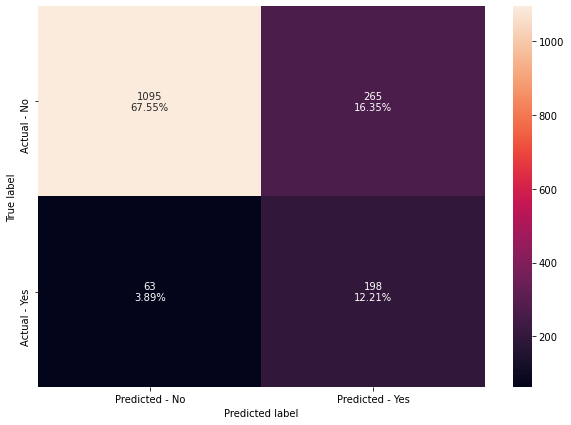

In [46]:
# check metrics scores
log_score = get_metrics_score(log_over)

# make a confusion matrix of our predictions
make_confusion_matrix(log_over, y_val)

#### Decision Tree

In [47]:
# Decision Tree
dtree_over = DecisionTreeClassifier(random_state = 1)
dtree_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on validation set :  0.9185687847008019
Recall on training set :  1.0
Recall on validation set :  0.8122605363984674
Precision on training set :  1.0
Precision on validation set :  0.7186440677966102
F1 Score on training set :  1.0
F1 Score on validation set :  0.762589928057554


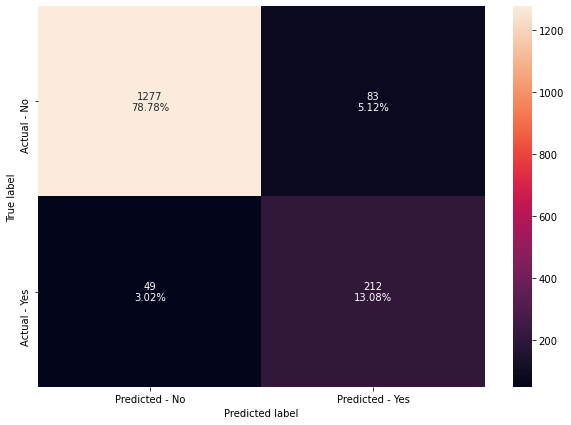

In [48]:
# check metrics scores
dtree_score = get_metrics_score(dtree_over)

# make a confusion matrix of our predictions
make_confusion_matrix(dtree_over, y_val)

#### Random Forest

In [49]:
# Random Forest
rf_over = RandomForestClassifier(random_state = 1)
rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on validation set :  0.9561998766193708
Recall on training set :  1.0
Recall on validation set :  0.8697318007662835
Precision on training set :  1.0
Precision on validation set :  0.8598484848484849
F1 Score on training set :  1.0
F1 Score on validation set :  0.8647619047619047


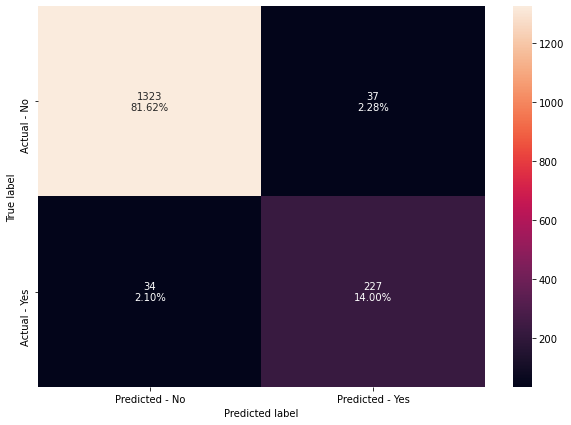

In [50]:
# check metrics scores
rf_score = get_metrics_score(rf_over)

# make a confusion matrix of our predictions
make_confusion_matrix(rf_over, y_val)

#### Bagging Classifier

In [51]:
# Bagging Classifier
bag_over = BaggingClassifier(random_state = 1)
bag_over.fit(X_train_over, y_train_over)

BaggingClassifier(random_state=1)

Accuracy on training set :  0.9978395061728395
Accuracy on validation set :  0.945712523133868
Recall on training set :  0.9971181556195965
Recall on validation set :  0.8735632183908046
Precision on training set :  0.9895138226882746
Precision on validation set :  0.8056537102473498
F1 Score on training set :  0.9933014354066985
F1 Score on validation set :  0.8382352941176471


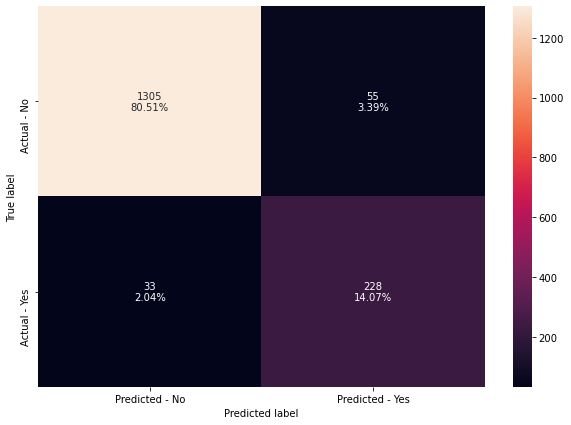

In [52]:
# check metrics scores
bag_score = get_metrics_score(bag_over)

# make a confusion matrix of our predictions
make_confusion_matrix(bag_over, y_val)

#### AdaBoost

In [53]:
# AdaBoost
abc_over = AdaBoostClassifier(random_state = 1)
abc_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(random_state=1)

Accuracy on training set :  0.9479938271604939
Accuracy on validation set :  0.9506477483035164
Recall on training set :  0.8895292987512008
Recall on validation set :  0.8850574712643678
Precision on training set :  0.8066202090592335
Precision on validation set :  0.8220640569395018
F1 Score on training set :  0.8460484239378713
F1 Score on validation set :  0.8523985239852399


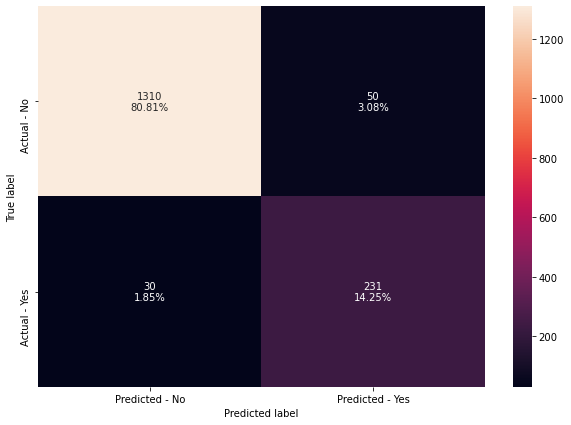

In [54]:
# check metrics scores
abc_score = get_metrics_score(abc_over)

# make a confusion matrix of our predictions
make_confusion_matrix(abc_over, y_val)

#### XGBoost

In [55]:
# XGBoost
xgb_over = XGBClassifier(random_state = 1)
xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy on training set :  1.0
Accuracy on validation set :  0.9673041332510796
Recall on training set :  1.0
Recall on validation set :  0.9195402298850575
Precision on training set :  1.0
Precision on validation set :  0.8823529411764706
F1 Score on training set :  1.0
F1 Score on validation set :  0.900562851782364


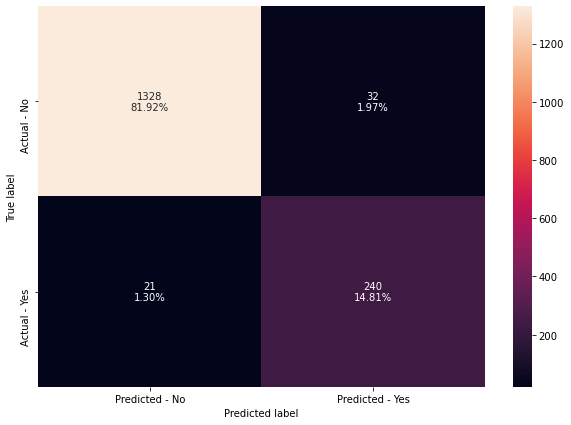

In [56]:
# check metrics scores
xgb_score = get_metrics_score(xgb_over)

# make a confusion matrix of our predictions
make_confusion_matrix(xgb_over, y_val)

In [57]:
# comparing model performance of oversampled models
# defining list of models
models = [log_over, dtree_over, rf_over, bag_over, abc_over, xgb_over,
          ]

# defining empty lists to add train and validation results
acc_train = []
acc_val = []
recall_train = []
recall_val = []
precision_train = []
precision_val = []
f1_train = []
f1_val = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_val.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_val.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_val.append(np.round(j[5],2))
    f1_train.append(np.round(j[6],2))
    f1_val.append(np.round(j[7],2))

In [58]:
comparison_frame_over = pd.DataFrame({'Model':['Logistic Regression','Decision Tree',
                                        'Random Forest', 'Bagging Classifier', 
                                         'AdaBoost Classifier', "XGBoost Classifier"], 
                                          'Train_Accuracy': acc_train,'Validation_Accuracy': acc_val,
                                          'Train_Recall': recall_train,'Validation_Recall': recall_val,
                                          'Train_Precision': precision_train,'Validation_Precision': precision_val,
                                          'Train_F1_Score': f1_train, 'Validation_F1_Score': f1_val}) 
comparison_frame_over

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,Logistic Regression,0.79,0.80,0.77,0.76,0.42,0.43,0.54,0.55
1,Decision Tree,1.00,0.92,1.00,0.81,1.00,0.72,1.00,0.76
2,Random Forest,1.00,0.96,1.00,0.87,1.00,0.86,1.00,0.86
3,Bagging Classifier,1.00,0.95,1.00,0.87,0.99,0.81,0.99,0.84
4,AdaBoost Classifier,0.95,0.95,0.89,0.89,0.81,0.82,0.85,0.85
5,XGBoost Classifier,1.00,0.97,1.00,0.92,1.00,0.88,1.00,0.90


- Most of the models had an increase in validation recall
- The Adaboost model is still the best performing while not overfitting, and the XGBoost model still has the best overall validation recall
- All models are overfitting less than they were on the unbalanced data

### Undersampling

I am now going to try undersampling using the RandomUnderSampler. The undersampling method aims to balance the data as well, but instead of adding synthetic data to the minority class, it removes data from the majority class. I will fit the 6 models on the undersampled data and compare their performance to the unbalanced and oversampled data.

In [59]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state = 1, sampling_strategy = 1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [60]:
# check that the data is now undersampled and that there are equal weights in both target classes
y_train_under.value_counts(normalize = False)

0    1041
1    1041
Name: Attrition_Flag, dtype: int64

In [61]:
# check that the data is now undersampled and that there are equal weights in both target classes
y_train_over.value_counts(normalize = True)

0    0.5
1    0.5
Name: Attrition_Flag, dtype: float64

The data is evenly balanced, but there is much less data than the oversampled data.

#### Logistic Regression

In [62]:
# Logistic Regression
log_under = LogisticRegression(random_state = 1)
log_under.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1)

Accuracy on training set :  0.812037037037037
Accuracy on validation set :  0.8167797655768044
Recall on training set :  0.8155619596541787
Recall on validation set :  0.8237547892720306
Precision on training set :  0.4528
Precision on validation set :  0.4613733905579399
F1 Score on training set :  0.5823045267489712
F1 Score on validation set :  0.5914718019257221


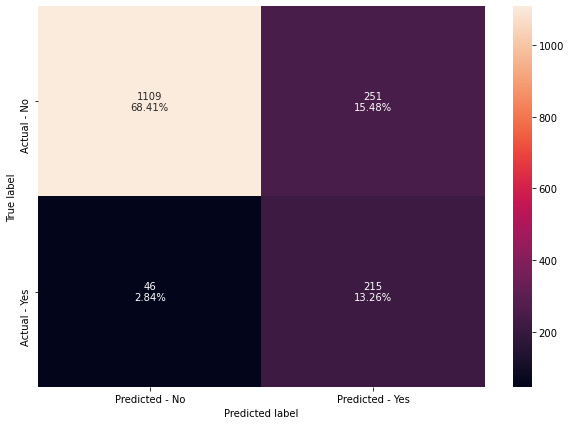

In [63]:
# check metrics scores
log_score = get_metrics_score(log_under)

# make a confusion matrix of our predictions
make_confusion_matrix(log_under, y_val)

#### Decision Tree

In [64]:
# Decision Tree
dtree_under = DecisionTreeClassifier(random_state = 1)
dtree_under.fit(X_train_under, y_train_under)

DecisionTreeClassifier(random_state=1)

Accuracy on training set :  0.9277777777777778
Accuracy on validation set :  0.8994447871684146
Recall on training set :  1.0
Recall on validation set :  0.89272030651341
Precision on training set :  0.6898608349900597
Precision on validation set :  0.6331521739130435
F1 Score on training set :  0.8164705882352942
F1 Score on validation set :  0.7408585055643878


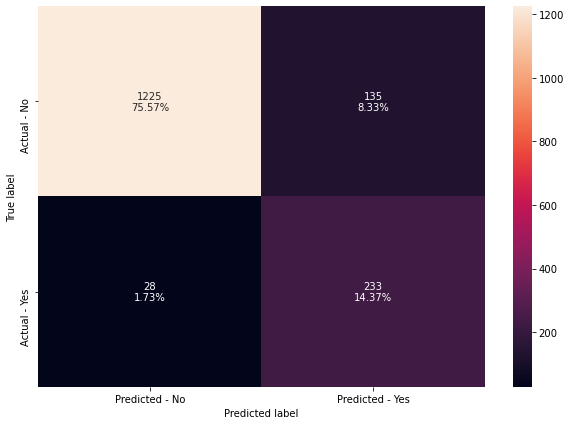

In [65]:
# check metrics scores
dtree_score = get_metrics_score(dtree_under)

# make a confusion matrix of our predictions
make_confusion_matrix(dtree_under, y_val)

#### Random Forest

In [66]:
# Random Forest
rf_under = RandomForestClassifier(random_state = 1)
rf_under.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=1)

Accuracy on training set :  0.9484567901234567
Accuracy on validation set :  0.9358420727945712
Recall on training set :  1.0
Recall on validation set :  0.9578544061302682
Precision on training set :  0.757090909090909
Precision on validation set :  0.7288629737609329
F1 Score on training set :  0.8617549668874172
F1 Score on validation set :  0.8278145695364238


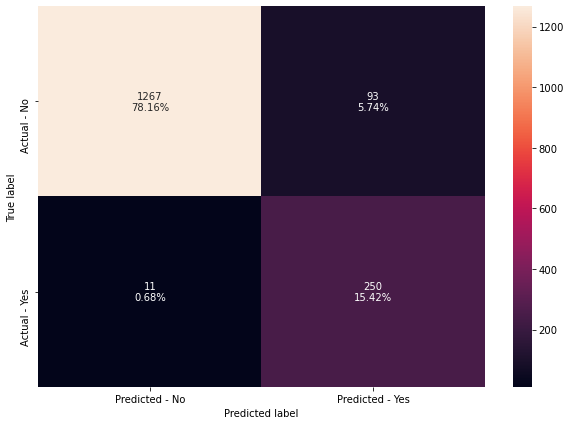

In [67]:
# check metrics scores
rf_score = get_metrics_score(rf_under)

# make a confusion matrix of our predictions
make_confusion_matrix(rf_under, y_val)

#### Bagging Classifier

In [68]:
# Bagging Classifier
bag_under = BaggingClassifier(random_state = 1)
bag_under.fit(X_train_under, y_train_under)

BaggingClassifier(random_state=1)

Accuracy on training set :  0.9439814814814815
Accuracy on validation set :  0.9265885256014805
Recall on training set :  0.9951969260326609
Recall on validation set :  0.9386973180076629
Precision on training set :  0.7431850789096126
Precision on validation set :  0.7040229885057471
F1 Score on training set :  0.8509240246406571
F1 Score on validation set :  0.8045977011494253


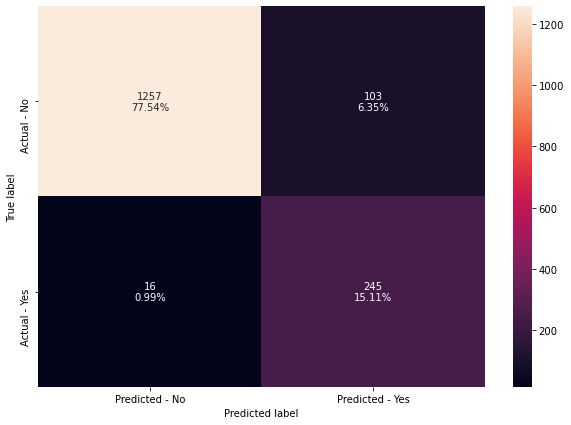

In [69]:
# check metrics scores
bag_score = get_metrics_score(bag_under)

# make a confusion matrix of our predictions
make_confusion_matrix(bag_under, y_val)

#### AdaBoost

In [70]:
# AdaBoost
abc_under = AdaBoostClassifier(random_state = 1)
abc_under.fit(X_train_under, y_train_under)

AdaBoostClassifier(random_state=1)

Accuracy on training set :  0.9276234567901235
Accuracy on validation set :  0.9253547193090684
Recall on training set :  0.9567723342939481
Recall on validation set :  0.9540229885057471
Precision on training set :  0.7014084507042253
Precision on validation set :  0.6955307262569832
F1 Score on training set :  0.8094270621698496
F1 Score on validation set :  0.8045234248788368


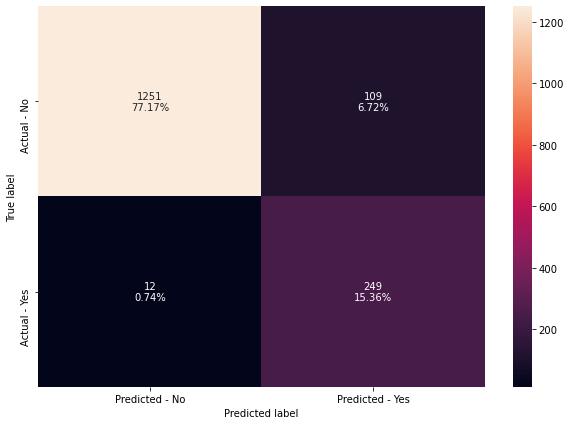

In [71]:
# check metrics scores
abc_score = get_metrics_score(abc_under)

# make a confusion matrix of our predictions
make_confusion_matrix(abc_under, y_val)

#### XGBoost

In [72]:
# XGBoost
xgb_under = XGBClassifier(random_state = 1)
xgb_under.fit(X_train_under, y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy on training set :  0.9498456790123457
Accuracy on validation set :  0.9444787168414559
Recall on training set :  1.0
Recall on validation set :  0.9693486590038314
Precision on training set :  0.7620790629575402
Precision on validation set :  0.755223880597015
F1 Score on training set :  0.8649771499792273
F1 Score on validation set :  0.8489932885906041


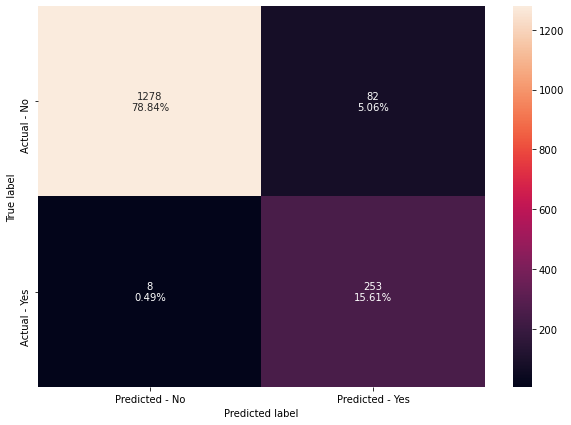

In [73]:
# check metrics scores
xgb_score = get_metrics_score(xgb_under)

# make a confusion matrix of our predictions
make_confusion_matrix(xgb_under, y_val)

In [74]:
# comparing model performance of undersampled models
# defining list of models
models = [log_under, dtree_under, rf_under, bag_under, abc_under, xgb_under,
          ]

# defining empty lists to add train and validation results
acc_train = []
acc_val = []
recall_train = []
recall_val = []
precision_train = []
precision_val = []
f1_train = []
f1_val = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_val.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_val.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_val.append(np.round(j[5],2))
    f1_train.append(np.round(j[6],2))
    f1_val.append(np.round(j[7],2))

In [75]:
comparison_frame_under = pd.DataFrame({'Model':['Logistic Regression','Decision Tree',
                                        'Random Forest', 'Bagging Classifier', 
                                         'AdaBoost Classifier', "XGBoost Classifier"], 
                                          'Train_Accuracy': acc_train,'Validation_Accuracy': acc_val,
                                          'Train_Recall': recall_train,'Validation_Recall': recall_val,
                                          'Train_Precision': precision_train,'Validation_Precision': precision_val,
                                          'Train_F1_Score': f1_train, 'Validation_F1_Score': f1_val}) 
comparison_frame_under

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,Logistic Regression,0.81,0.82,0.82,0.82,0.45,0.46,0.58,0.59
1,Decision Tree,0.93,0.90,1.00,0.89,0.69,0.63,0.82,0.74
2,Random Forest,0.95,0.94,1.00,0.96,0.76,0.73,0.86,0.83
3,Bagging Classifier,0.94,0.93,1.00,0.94,0.74,0.70,0.85,0.80
4,AdaBoost Classifier,0.93,0.93,0.96,0.95,0.70,0.70,0.81,0.80
5,XGBoost Classifier,0.95,0.94,1.00,0.97,0.76,0.76,0.86,0.85


- Interestingly the models fit to the undersampled data performed the best, despite using the smallest amount of data to train the models
- The Adaboost model continues to perform the best without overfitting, however, the XGBoost model is now barely overfitting with the increased validation recall
- Overall all the models had increased performance in validation recall
- However, we notice a drop in f1 scores across all models when compared to the oversampled data
- Interestingly, the unbalanced data provided the best f1 scores despite being unbalanced
- The undersampling technique worked the best to improve recall score, which is our primary performance metric
- The oversampling method improved recall scores and provided comparable f1 scores to the unbalanced data

In [76]:
# unbalanced data model performance
comparison_frame

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,Logistic Regression,0.88,0.89,0.38,0.43,0.78,0.79,0.52,0.56
1,Decision Tree,1.00,0.95,1.00,0.83,1.00,0.83,1.00,0.83
2,Random Forest,1.00,0.96,1.00,0.80,1.00,0.92,1.00,0.86
3,Bagging Classifier,1.00,0.95,0.98,0.82,1.00,0.89,0.99,0.85
4,AdaBoost Classifier,0.96,0.96,0.84,0.84,0.89,0.88,0.87,0.86
5,XGBoost Classifier,1.00,0.97,1.00,0.89,1.00,0.92,1.00,0.91


In [77]:
# oversampled data model performance
comparison_frame_over

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,Logistic Regression,0.79,0.80,0.77,0.76,0.42,0.43,0.54,0.55
1,Decision Tree,1.00,0.92,1.00,0.81,1.00,0.72,1.00,0.76
2,Random Forest,1.00,0.96,1.00,0.87,1.00,0.86,1.00,0.86
3,Bagging Classifier,1.00,0.95,1.00,0.87,0.99,0.81,0.99,0.84
4,AdaBoost Classifier,0.95,0.95,0.89,0.89,0.81,0.82,0.85,0.85
5,XGBoost Classifier,1.00,0.97,1.00,0.92,1.00,0.88,1.00,0.90


### Hyperparameter Tuning

Now, I am going to try hyperparameter tuning some of the models using the RandomSearchCV method. This should hopefully improve the performance of the models, and ultimately give us a model that is robust enough to be confidently implemented into a pipeline, which could be productionalized. The models I am choosing to tune are: 1. The undersampled XGBoost model as it had the highest recall overall, and was not overfitting too much, but we can shoot for perfect recall 2. The default Adaboost model as it could improve its recall score, but it had a pretty good f1 score even on unbalanced data 3. The undersampled decision tree model to see if we can get a simple interpretable model to have similar performance to the boosting models as that would be preferred. At this stage I will also evaluate these three tuned models using the test set to finally test their performance in a production environment.

#### Tuned XGBoost

In [78]:
# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(10, 100, 20),
    "scale_pos_weight": np.arange(0, 5, 1),
    "subsample": np.arange(0.5, 1, 0.1),
    "learning_rate": np.arange(0.01, 0.2, 0.01),
    "gamma":  np.arange(0, 3, 1),
    "colsample_bytree": np.arange(0.5, 1, 0.1),
    "colsample_bylevel": np.arange(0.5, 1, 0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator = xgb_under, param_distributions = parameters, n_jobs = -1, n_iter = 50,
                              scoring = acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train_under, y_train_under)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train_under, y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.04, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy on training set :  0.8577160493827161
Accuracy on validation set :  0.8525601480567551
Recall on training set :  1.0
Recall on validation set :  0.9846743295019157
Precision on training set :  0.5303107488537953
Precision on validation set :  0.5223577235772358
F1 Score on training set :  0.6930758988015979
F1 Score on validation set :  0.6826029216467463


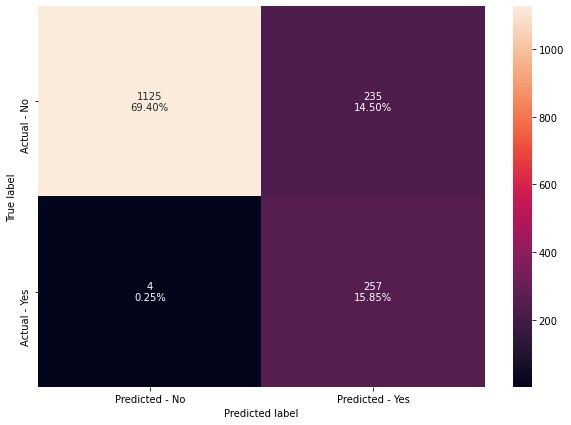

In [79]:
# check metrics scores
xgb_score = get_metrics_score(xgb_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix(xgb_tuned, y_val)

#### Tuned Adaboost

In [80]:
# Grid of parameters to choose from
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth = 1, random_state = 1),
                      DecisionTreeClassifier(max_depth = 2, random_state = 1),
                      DecisionTreeClassifier(max_depth = 3, random_state = 1)],
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": np.arange(0.1, 2, 0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator = abc, param_distributions = parameters, n_jobs = -1, 
                              n_iter = 50, scoring = acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.1, n_estimators=90, random_state=1)

Accuracy on training set :  0.9944444444444445
Accuracy on validation set :  0.9691548426896978
Recall on training set :  0.9846301633045149
Recall on validation set :  0.8773946360153256
Precision on training set :  0.9808612440191388
Precision on validation set :  0.9271255060728745
F1 Score on training set :  0.9827420901246405
F1 Score on validation set :  0.9015748031496064


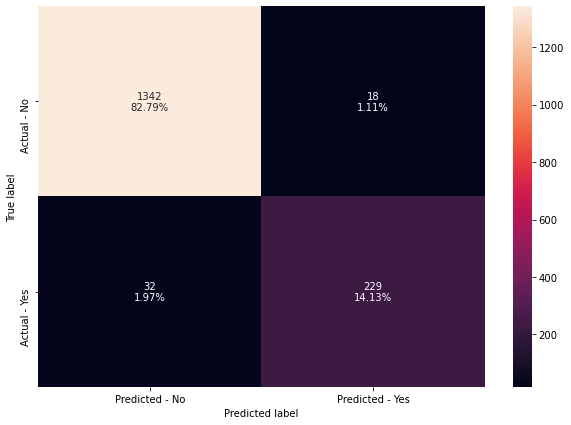

In [81]:
# check metrics scores
abc_score = get_metrics_score(abc_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix(abc_tuned, y_val)

#### Tuned Decision Tree

In [82]:
# Choose the type of classifier.
dtree_tuned = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(1, 15, 1),
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": np.arange(0.0001, 0.1, 0.00001),
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator = dtree_under, param_distributions = parameters, n_jobs = -1, 
                              n_iter = 50, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train_under, y_train_under)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data
dtree_tuned.fit(X_train_under, y_train_under)

DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_impurity_decrease=0.06669, random_state=1)

Accuracy on training set :  0.7455246913580247
Accuracy on validation set :  0.7550894509561998
Recall on training set :  0.9548511047070125
Recall on validation set :  0.9540229885057471
Precision on training set :  0.3828967642526965
Precision on validation set :  0.39274447949526814
F1 Score on training set :  0.5466043442397581
F1 Score on validation set :  0.5564245810055867


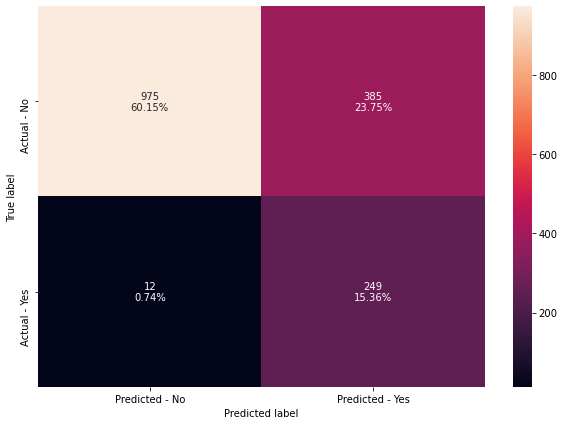

In [83]:
# check metrics scores
dtree_score = get_metrics_score(dtree_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix(dtree_tuned, y_val)

#### Model Performance on the Test Set

Now that we have seen some improvement in the validation recall scores for the tuned models, let's finally test them on the test dataset to see thier performance in a production environment, with unseen unbalanced data.

In [84]:
##  Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and f1 score
## Uses the test set for model evaluation
def get_metrics_score_test(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    #f1 score of the model
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision, train_f1, test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print("F1 Score on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1 Score on test set : ",metrics.f1_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [85]:
## Function to create confusion matrix using test set for evaluation
def make_confusion_matrix_test(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Tuned XGBoost Test Performance

Accuracy on training set :  0.8577160493827161
Accuracy on test set :  0.8568608094768015
Recall on training set :  1.0
Recall on test set :  0.9969230769230769
Precision on training set :  0.5303107488537953
Precision on test set :  0.5285481239804242
F1 Score on training set :  0.6930758988015979
F1 Score on test set :  0.6908315565031984


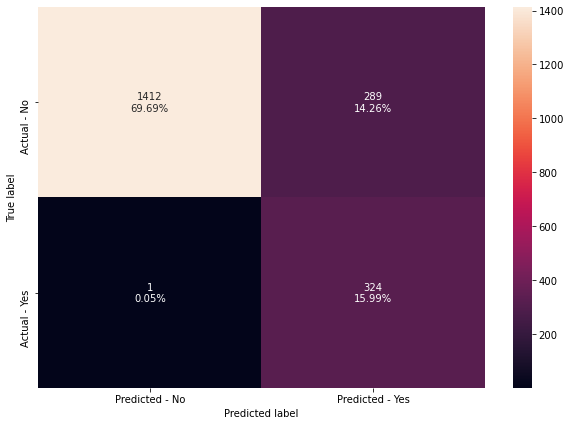

In [86]:
# check metrics scores
xgb_score_test = get_metrics_score_test(xgb_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix_test(xgb_tuned, y_test)

### Tuned AdaBoost Test Performance

Accuracy on training set :  0.9944444444444445
Accuracy on test set :  0.9713721618953604
Recall on training set :  0.9846301633045149
Recall on test set :  0.9076923076923077
Precision on training set :  0.9808612440191388
Precision on test set :  0.913312693498452
F1 Score on training set :  0.9827420901246405
F1 Score on test set :  0.9104938271604938


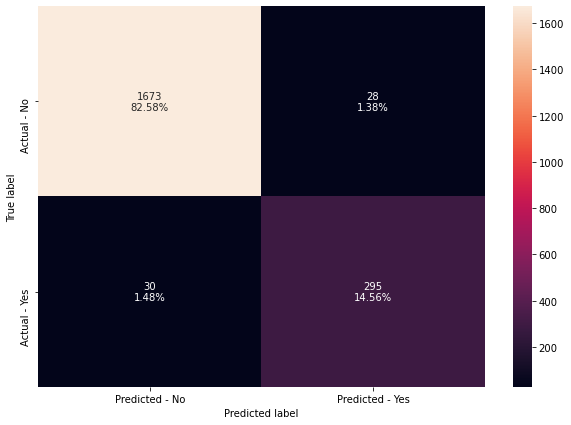

In [87]:
# check metrics scores
abc_score_test = get_metrics_score_test(abc_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix_test(abc_tuned, y_test)

### Tuned Decision Tree Test Performance

Accuracy on training set :  0.7455246913580247
Accuracy on test set :  0.7472852912142152
Recall on training set :  0.9548511047070125
Recall on test set :  0.96
Precision on training set :  0.3828967642526965
Precision on test set :  0.3847102342786683
F1 Score on training set :  0.5466043442397581
F1 Score on test set :  0.5492957746478873


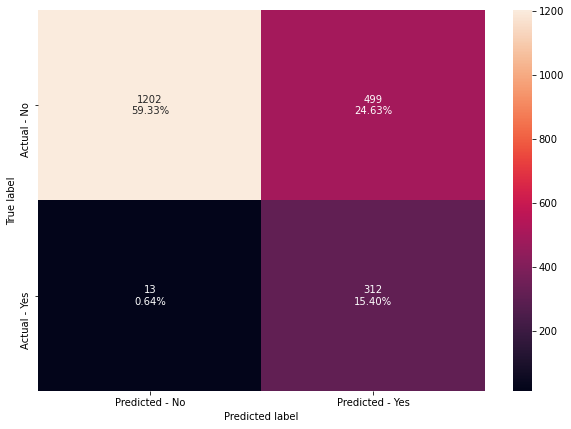

In [88]:
# check metrics scores
dtree_score_test = get_metrics_score_test(dtree_tuned)

# make a confusion matrix of our predictions
make_confusion_matrix_test(dtree_tuned, y_test)

In [89]:
# comparing model performance of undersampled models
# defining list of models
models = [xgb_tuned, abc_tuned, dtree_tuned,
          ]

# defining empty lists to add train and validation results
acc_train = []
acc_val = []
recall_train = []
recall_val = []
precision_train = []
precision_val = []
f1_train = []
f1_val = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_val.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_val.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_val.append(np.round(j[5],2))
    f1_train.append(np.round(j[6],2))
    f1_val.append(np.round(j[7],2))

In [90]:
# comparing model performance of undersampled models
# defining list of models
models = [xgb_tuned, abc_tuned, dtree_tuned,
          ]

# defining empty lists to add train and validation results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    k = get_metrics_score_test(model, False)
    acc_train.append(np.round(k[0],2))
    acc_test.append(np.round(k[1],2))
    recall_train.append(np.round(k[2],2))
    recall_test.append(np.round(k[3],2))
    precision_train.append(np.round(k[4],2))
    precision_test.append(np.round(k[5],2))
    f1_train.append(np.round(k[6],2))
    f1_test.append(np.round(k[7],2))

In [91]:
comparison_frame_tuned_val = pd.DataFrame({'Model':['XGBoost Under Tuned','AdaBoost Unbalanced Tuned',
                                        'Decision Tree Under Tuned'], 
                                          'Train_Accuracy': acc_train,'Validation_Accuracy': acc_val,
                                          'Train_Recall': recall_train,'Validation_Recall': recall_val,
                                          'Train_Precision': precision_train,'Validation_Precision': precision_val,
                                          'Train_F1_Score': f1_train, 'Validation_F1_Score': f1_val}) 
comparison_frame_tuned_val

,Model,Train_Accuracy,Validation_Accuracy,Train_Recall,Validation_Recall,Train_Precision,Validation_Precision,Train_F1_Score,Validation_F1_Score
0,XGBoost Under Tuned,0.86,0.85,1.00,0.98,0.53,0.52,0.69,0.68
1,AdaBoost Unbalanced Tuned,0.99,0.97,0.98,0.88,0.98,0.93,0.98,0.90
2,Decision Tree Under Tuned,0.75,0.76,0.95,0.95,0.38,0.39,0.55,0.56


In [92]:
comparison_frame_tuned_test = pd.DataFrame({'Model':['XGBoost Under Tuned','AdaBoost Unbalanced Tuned',
                                        'Decision Tree Under Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall': recall_train,'Test_Recall': recall_test,
                                          'Train_Precision': precision_train,'Test_Precision': precision_test,
                                          'Train_F1_Score': f1_train, 'Test_F1_Score': f1_test}) 
comparison_frame_tuned_test

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1_Score,Test_F1_Score
0,XGBoost Under Tuned,0.86,0.86,1.00,1.00,0.53,0.53,0.69,0.69
1,AdaBoost Unbalanced Tuned,0.99,0.97,0.98,0.91,0.98,0.91,0.98,0.91
2,Decision Tree Under Tuned,0.75,0.75,0.95,0.96,0.38,0.38,0.55,0.55


- After tuning the models we see a great improvement in their performance
- Most notably, the XGBoost model has perfect recall in the test set, making it a great candidate for a production model
- We also see very high performance from the decision tree model, which is very good as the decision tree model is interpretable
    - It also overfit the data less than the adaboost model, which is interesting as the decision tree models are likely to overfit after tuning
- The Adaboost model has the best overall performance with the highest f1 score, so based on the use case of the model, this could be a great choice
- For this analysis, since we value recall, I will pick the xgboost model to be used in the pipeline 

Let's look at the feature imortance of these three models to get an idea of what features are impacting these customers decisions to close their accounts.

In [93]:
# xgboost tuned feature importance
print(
    pd.DataFrame(
        xgb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns
    ).sort_values(by = "Imp", ascending = False)
)

                                     Imp
Total_Trans_Ct                  0.127200
Total_Trans_Amt                 0.121483
Total_Revolving_Bal             0.103121
Total_Ct_Chng_Q4_Q1             0.066014
Total_Amt_Chng_Q4_Q1            0.063220
Avg_Utilization_Ratio           0.055528
Total_Relationship_Count        0.047182
Months_Inactive_12_mon          0.042804
Contacts_Count_12_mon           0.039784
Credit_Limit                    0.035656
Avg_Open_To_Buy                 0.032641
Customer_Age                    0.029648
Months_on_book                  0.023402
Education_Level_Post-Graduate   0.022618
Income_Category_$40K - $60K     0.020525
Marital_Status_Married          0.020336
Dependent_count                 0.019884
Card_Category_Gold              0.018496
Gender_M                        0.018312
Marital_Status_Single           0.017449
Card_Category_Silver            0.013156
Income_Category_$60K - $80K     0.011691
Income_Category_Less than $40K  0.011619
Income_Category_

In [94]:
# adaboost tuned feature importance
print(
    pd.DataFrame(
        abc_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns
    ).sort_values(by = "Imp", ascending = False)
)

                                     Imp
Total_Trans_Amt                 0.219664
Total_Amt_Chng_Q4_Q1            0.146099
Total_Trans_Ct                  0.104826
Credit_Limit                    0.085604
Total_Ct_Chng_Q4_Q1             0.063400
Avg_Open_To_Buy                 0.056126
Customer_Age                    0.054073
Total_Revolving_Bal             0.052329
Total_Relationship_Count        0.042850
Months_on_book                  0.031666
Contacts_Count_12_mon           0.030460
Months_Inactive_12_mon          0.027529
Dependent_count                 0.023367
Avg_Utilization_Ratio           0.021389
Gender_M                        0.009087
Card_Category_Platinum          0.005352
Income_Category_$80K - $120K    0.004840
Education_Level_Uneducated      0.004590
Marital_Status_Single           0.003933
Income_Category_$60K - $80K     0.003844
Marital_Status_Married          0.003167
Education_Level_High School     0.002990
Income_Category_$40K - $60K     0.002817
Education_Level_

In [95]:
# decision tree tuned feature importance
print(
    pd.DataFrame(
        dtree_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns
    ).sort_values(by = "Imp", ascending = False)
)

                                     Imp
Total_Trans_Ct                  0.670748
Total_Revolving_Bal             0.185813
Total_Trans_Amt                 0.143439
Customer_Age                    0.000000
Education_Level_Graduate        0.000000
Card_Category_Platinum          0.000000
Card_Category_Gold              0.000000
Income_Category_Less than $40K  0.000000
Income_Category_$80K - $120K    0.000000
Income_Category_$60K - $80K     0.000000
Income_Category_$40K - $60K     0.000000
Marital_Status_Single           0.000000
Marital_Status_Married          0.000000
Education_Level_Uneducated      0.000000
Education_Level_Post-Graduate   0.000000
Education_Level_High School     0.000000
Gender_M                        0.000000
Education_Level_Doctorate       0.000000
Dependent_count                 0.000000
Avg_Utilization_Ratio           0.000000
Total_Ct_Chng_Q4_Q1             0.000000
Total_Amt_Chng_Q4_Q1            0.000000
Avg_Open_To_Buy                 0.000000
Credit_Limit    

- The most important feature across all models is the total transaction count, while total transaction amount, and total revolving balance are also important

## XGBoost Model Pipeline

In [96]:
# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

In [97]:
# defining pipe using make_pipeline, we use the tuned xgboost model
pipe = make_pipeline(StandardScaler(), (xgb_tuned)) 

In [98]:
# fit the pipe object to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=0.7, colsample_bynode=1,
                               colsample_bytree=0.5, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=2, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.04, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=70, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=1, reg_alpha=0,
                               reg_lambda=1, ...))])

Accuracy on training set :  0.971141975308642
Accuracy on test set :  0.9654491609081934
Recall on training set :  0.9721421709894332
Recall on test set :  0.9415384615384615
Precision on training set :  0.864957264957265
Precision on test set :  0.8571428571428571
F1 Score on training set :  0.9154228855721395
F1 Score on test set :  0.8973607038123167


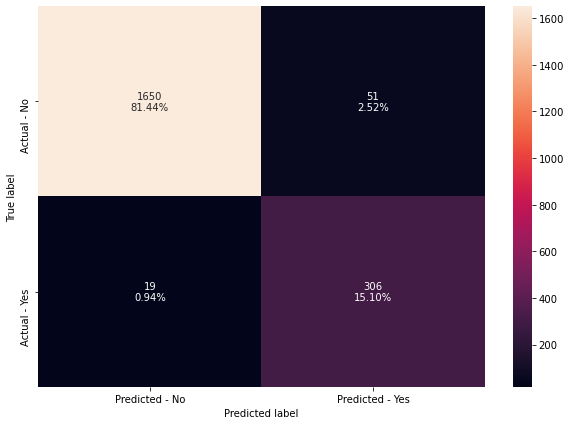

In [99]:
# check metrics scores
pipe_score_test = get_metrics_score_test(pipe)

# pipe object's confusion matrix on test data
make_confusion_matrix_test(pipe, y_test)

Our pipeline model has pretty good performance, doesn't seem to be overfitting much, and is now easy to reuse!

## Recommendations and Insights

- The most important factors when determining if a customer is going to close their credit card account are the total transaction count and amount, as well as the total revolving balance of the customer
    - Based on the EDA, customers with a total revolving balance of less than 500, were more likely to close their accounts
    - Customers with a total transaction count of greater than 100 transactions in the past year were very unlikely to close their account
    - Similarly, customers with a total transaction amount of greater than 12500 in the past year were very unlikely to close their account
- It is interesting that customers with the lowest revolving balance were likely to close their accounts
    - This may be caused by customers who can not keep up with their payments due to financial struggles, and are forced to close their accounts
    - The bank could offer more lenient payment options for lower income customers who may find it difficult to make the monthly credit card payments, in order to retain these customers
    - This would however, cause the bank to take on more risk as there is a possibility that the bank loses money if these customers are not able to make the payments
- We were able to create a model that was very accurate in the tuned XGBoost model that could be implemented into a pipline to provide reusable, robust predictions by identifying customers who were likely to close their accounts
    - Using this information, the bank could profile their customers and offer benefits like cash back programs to incentivize spending as the highest spending customers with high transaction amounts and counts were unlikely to close their accounts